In [9]:
from glob import glob
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from modules.metadata import PhotoMetadata
from modules.utilities import str_to_datetime

location_data_dirpath = '../../data/locations/'
semantic_locations_path = join(location_data_dirpath, 'semantic_locations.hdf')

pings_data_path = join(location_data_dirpath, 'pings.hdf')
photo_metadata_dirpath = '../../data/photo_metadata'
photo_metadata_path = join(photo_metadata_dirpath, 'photo_metadata.hdf')
photo_gps_path = join(photo_metadata_dirpath, 'photo_gps.hdf')
photo_semantic_locations_path = join(photo_metadata_dirpath, 'photo_semantic_locations.hdf')

%reload_ext autoreload
%autoreload 2

In [10]:
# load metadata
photo_metadata = PhotoMetadata(photo_metadata_path)

# load ping data
pings = pd.read_hdf(pings_data_path, 'data')

# load locations
semantic_locations = pd.read_hdf(semantic_locations_path, 'data')

# Compile Photo GPS from nearest ping

In [11]:
def compute_timedelta(series, time_column):
    dt = (series.index - series[time_column])
    return dt.apply(lambda x: abs(x.total_seconds()))

In [12]:
photo_metadata.data = photo_metadata.data.sort_values('timestamp')

In [13]:
min_ping_accuracy = 100 # meters

# load pings and filter by accuracy
pings = pings[~pings.index.duplicated()]
pings['time_ping'] = pings.index
pings = pings[pings.accuracy < min_ping_accuracy]

# match photos with nearest ping
photo_times = photo_metadata.data.timestamp
columns_without_altitude = ['latitude', 'longitude', 'accuracy', 'owner', 'time_ping']
photo_gps = pd.merge_asof(photo_times, pings[columns_without_altitude], left_on='timestamp', right_index=True, direction='nearest')
photo_gps = photo_gps.set_index('timestamp')
photo_gps['dt_ping'] = compute_timedelta(photo_gps, 'time_ping')

In [14]:
np.percentile(photo_gps.dt_ping, 90)

2596.5315999999993

Text(0, 0.5, 'Num. photos')

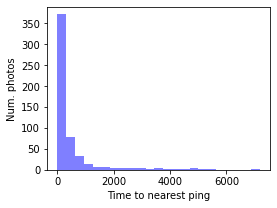

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))
bins = np.linspace(0, 3600*2, 24)
_ = ax.hist(photo_gps.dt_ping, bins=bins, color='b', alpha=0.5)
ax.set_xlabel('Time to nearest ping')
ax.set_ylabel('Num. photos')

In [8]:
# save photo gps
photo_gps.to_hdf(join(photo_metadata_dirpath, 'photo_gps.hdf'), 'data')

# Match semantic locations

In [16]:
from scipy import spatial
import numpy as np

from modules.utilities import haversine

def locate_photos(photo_positions, semantic_locations):
    location_positions = semantic_locations[['latitude', 'longitude']].values
    tree = spatial.KDTree(location_positions)
    _, idxs = tree.query(photo_positions, p=1)
    distances = np.array([haversine(p1, p2) for p1, p2 in zip(photo_positions, location_positions[idxs])])   
    return distances, idxs

def build_caption(record):
    
    max_distance_for_name = 0.5
    max_distance_for_city = 5
    
    if record.distance_to_semantic >= max_distance_for_city:
        return None
    
    elif record.distance_to_semantic >= max_distance_for_name or type(record['name']) != str:
        return record.location_str
    
    else:        
        name = record['name'].title()
        return '{:s} - {:s}'.format(name, record.location_str)    

### Select photos with reliable GPS

In [17]:
# append ping-based location data where GPS tag is missing
df = photo_metadata.data.join(photo_gps, on='timestamp', lsuffix='_native', rsuffix='_ping')
df['latitude'] = df.latitude_native.fillna(df.latitude_ping)
df['longitude'] = df.longitude_native.fillna(df.longitude_ping)

# exclude unreliable pings
max_dt_ping = 3600/8 # 15 minutes
no_gps_data = (~df.geotagged & (df.dt_ping >= max_dt_ping))
df.loc[no_gps_data, ['latitude', 'longitude']] = float('nan')

# select photos with reliable gps
photos_with_gps = df[~df.latitude.isna()]

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Match photos to semantic locations

In [18]:
photo_positions = photos_with_gps[['latitude', 'longitude']].values
distance_to_semantic, idxs = locate_photos(photo_positions, semantic_locations)
photo_semantic_locations = semantic_locations.iloc[idxs].set_index(photos_with_gps.index)
photo_semantic_locations['distance_to_semantic'] = distance_to_semantic

In [19]:
# build automated captions
photo_semantic_locations['caption'] = photo_semantic_locations.apply(build_caption, axis=1)
photo_semantic_locations['place_id'] = photo_semantic_locations['id']
photo_semantic_locations = photo_semantic_locations.drop('id', axis=1)

### Query GoogleMaps for photos with GPS but no semantic location

In [61]:
# look up missing items with google query

max_distance_for_city = 5
excluded_idx = photo_semantic_locations.distance_to_semantic >= max_distance_for_city
missing = photo_semantic_locations[excluded_idx]

In [63]:
# import googlemaps
# with open('../../data/keys.txt', 'r') as file:
#     api_key = file.read().strip()
# gmaps = googlemaps.Client(key=key)

# # QUERY GOOGLE PLACES API
# responses = {}
# for idx, gps in photos_with_gps.loc[missing.index][['latitude', 'longitude']].iterrows():
#     response = gmaps.reverse_geocode(gps.values)
#     img_path = photos_with_gps.loc[idx].path
#     responses[img_path] = response    
    
# import json
# with open(join(photo_metadata_dirpath, 'gmaps_results.json'), 'w') as file:
#     json.dump(responses, file)

### Compile google maps results

In [64]:
import json
with open(join(photo_metadata_dirpath, 'gmaps_results.json'), 'r') as file:
    geocodes = json.load(file)

records = []
for image_path, geocode in geocodes.items():
    for location in geocode:
        place_id = location['place_id']
        address = location['formatted_address']
        latitude = location['geometry']['location']['lat']
        longitude = location['geometry']['location']['lng']
        gps = np.array([latitude, longitude])
        record = dict(image_path=image_path, 
                      match_gps=gps, 
                      match_address=address, 
                      match_place_id=place_id)
        records.append(record)
df = pd.DataFrame(records)

In [77]:
matches = []
for image_path, locations in df.groupby('image_path'):
    image_record = photos_with_gps.loc[photos_with_gps.path==image_path].iloc[0]
    image_gps = (image_record.latitude, image_record.longitude)
    locations['distance_from_image'] = locations.match_gps.apply(lambda x: haversine(x, image_gps))
    match = locations.iloc[locations.distance_from_image.argmin()]
    
    matches.append(
        {
        'image_path': image_path,
        'gps': match.match_gps,
        'address': match.match_address,
        'place_id': match.match_place_id,
        'distance_from_image': match.distance_from_image}    
    )

matches = pd.DataFrame(matches, index=missing.index)

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [80]:
from modules.utilities import fmt_address
from modules.places import get_city_name, get_country_code, get_state_code, get_location_str

address_data = pd.DataFrame.from_records(matches.address.apply(fmt_address).values.tolist(), index=matches.index)
matches = matches.join(address_data)

# parse city/country
matches['city'] = matches.apply(get_city_name, axis=1)
matches['country_code'] = matches.country.apply(get_country_code)
matches['state_code'] = matches.apply(get_state_code, axis=1)
matches['caption'] = matches.apply(get_location_str, axis=1)

In [86]:
keys = ['city', 'state', 'country', 'caption', 'place_id']
photo_semantic_locations = pd.concat((photo_semantic_locations[~excluded_idx][keys], matches[keys]))
photo_semantic_locations.to_hdf(photo_semantic_locations_path, 'data')

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['city', 'state', 'country', 'caption', 'place_id'], dtype='object')]

  encoding=encoding,
